# Customer Life Value Model

Goal: 

Base Model:

Outcomes:

- 

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")

print("Packages successfully imported!")

Packages successfully imported!


#### Step 1: Load and Examine the Data

In [102]:
data = pd.read_csv('data/data_normal.csv').drop(columns = ['Unnamed: 0'])
data.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,0,-0.939761,4,1,0.754230,0.330381,0.996757,1,-0.120022,1
1,102,1,0.086720,2,2,-0.186319,-0.394236,0.132172,0,-0.640260,0
2,103,0,1.934386,0,0,-0.933192,-0.877314,-1.078247,1,1.143413,2
3,104,1,-0.734465,5,1,1.751261,1.538076,1.169674,0,-1.086179,1
4,105,1,-1.350354,3,2,-0.352721,0.088842,-0.040745,1,2.109570,2


In [103]:
data.columns

Index(['Customer ID', 'Gender', 'Age', 'City', 'Membership Type',
       'Total Spend', 'Items Purchased', 'Average Rating', 'Discount Applied',
       'Days Since Last Purchase', 'Satisfaction Level'],
      dtype='object')

#### Step 2: Define the Features and Target Variable

In [117]:
# Using Total Spend as the target variable
target = 'Total Spend'
features = data.columns.drop([target, 'Customer ID', 'Discount Applied'])

X = data[features]
y = data[target]

#### Step 3: Train-Test Split

In [155]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [156]:
# Initialize the Lasso model with an alpha value
lasso = Lasso(alpha=0.001, random_state=42)

# Train the model
lasso.fit(X_train, y_train)
# Predict on the test set
y_pred = lasso.predict(X_test)

# Calculate the Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Lasso Regression RMSE: {rmse:.4f}')


Lasso Regression RMSE: 0.0857


#### Step 4: Train the CLV Prediction Model


In [157]:
# Initialize and train the Gradient Boosting Regressor
clf = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [158]:
# Predict on the test set
y_pred = clf.predict(X_test)

In [159]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'CLV Model MSE:  {mse:.4f}')
print(f'CLV Model RMSE: {rmse:.4f}')

CLV Model MSE:  0.0019
CLV Model RMSE: 0.0441


#### Step 5: Implement A/B Testing


In [160]:
# Use 'Discount Applied' column to define control and test groups
control_group = data[data['Discount Applied'] == 0]['Total Spend']
test_group = data[data['Discount Applied'] == 1]['Total Spend']

# Simulate CLV after the marketing strategy is applied
data['Predicted_CLV_After_Offer'] = data['Total Spend'] * (1 + data['Discount Applied'] / 100)

data.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,Predicted_CLV_After_Offer
0,101,0,-0.939761,4,1,0.754230,0.330381,0.996757,1,-0.120022,1,0.761772
1,102,1,0.086720,2,2,-0.186319,-0.394236,0.132172,0,-0.640260,0,-0.186319
2,103,0,1.934386,0,0,-0.933192,-0.877314,-1.078247,1,1.143413,2,-0.942524
3,104,1,-0.734465,5,1,1.751261,1.538076,1.169674,0,-1.086179,1,1.751261
4,105,1,-1.350354,3,2,-0.352721,0.088842,-0.040745,1,2.109570,2,-0.356248


#### Step 6: Analyze A/B Test Results


In [162]:
# Perform a two-sample t-test (two-tailed by default)
t_stat, p_value_two_tailed = stats.ttest_ind(control_group, test_group, equal_var=False)

# Adjust p-value for one-tailed test (right-tailed)
p_value_one_tailed = p_value_two_tailed / 2

# Check if the test group mean is greater than the control group mean
if t_stat > 0 and p_value_one_tailed < 0.05:
    print("The discount group has a statistically significantly higher mean CLV than the control group.")
else:
    print("No statistically significant evidence that the discount group has a higher mean CLV than the control group.")

print(f'\nTest Group Mean CLV: {test_group.mean():.2f}')
print(f'Control Group Mean CLV: {control_group.mean():.2f}')
print(f'T-statistic: {t_stat:.2f}, P-value (one-tailed): {p_value_one_tailed:.4f}')


The discount group has a statistically significantly higher mean CLV than the control group.

Test Group Mean CLV: -0.17
Control Group Mean CLV: 0.17
T-statistic: 3.17, P-value (one-tailed): 0.0008


#### Step 8: Visualize the results using Seaborn

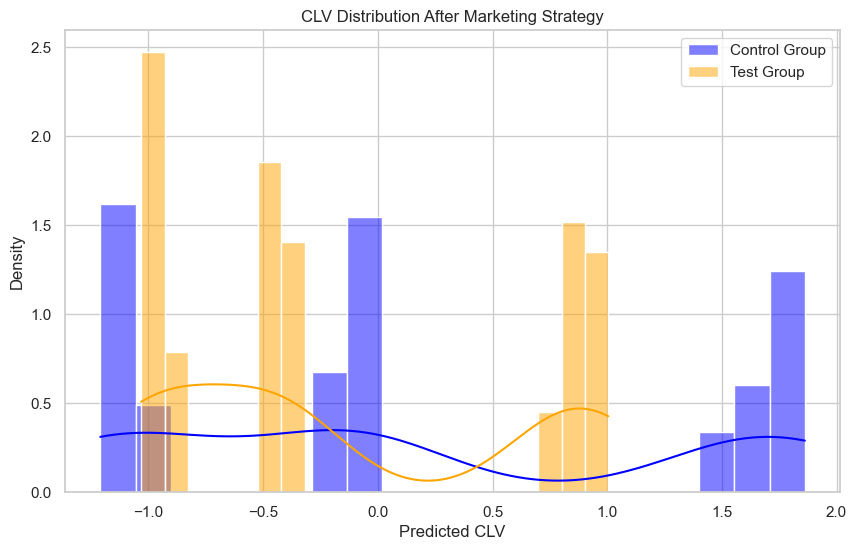

In [127]:
plt.figure(figsize=(10, 6))
sns.histplot(control_group, bins=20, kde=True, color='blue', label='Control Group', stat='density')
sns.histplot(test_group, bins=20, kde=True, color='orange', label='Test Group', stat='density')
plt.title('CLV Distribution After Marketing Strategy')
plt.xlabel('Predicted CLV')
plt.ylabel('Density')
plt.legend()
plt.show()